In [17]:
# Notes: For Emissions: "" and -- means missing
# For Energy_Use, "" is missing, For Energy_consumption -- means missing
# For Fossil_fuel_Energy both 0 and "" mean missing, can actually omit this and use renewable_energy instead (too much missing data)
#for GDP and Population -- means missing
# For Renewable_energy_cons "" means missing
# for Rents "" missing
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

import missingno as mno
from sklearn.impute import KNNImputer
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures


In [2]:
# Load all data and keep only those whose ISO matches all the datasets
countries = pd.read_excel("./countries.xlsx")

def getData(file):
    data = pd.read_csv(file, skiprows=1)
    
    data["Country"]=data["Country"].apply(lambda x: x.strip()) #strip trailing spaces
    data = data[data["Code"].isin(countries["Code"])] # check to see if it is in list
    data.reset_index(drop=True,inplace=True)
    
    return data

In [355]:
#Process all files and add them to a list of dataframes for easy manipulation

df_list = []
df_names = []
for filename in os.listdir("data_processed/"):
    #print(filename)
    path = "data_processed/" + filename
    df_list.append(getData(path))
    df_names.append(filename)

for i in range(15):
    
    print( 'Missing values:', clean_df(df_list[i]).isnull().sum().sum(), '\t File name:', df_names[i])


#mno.matrix(df_list[8], figsize = (10, 3))

Missing values: 88 	 File name: Emissions_Coal.csv
Missing values: 0 	 File name: Emissions_GHG_(fromCAIT).csv
Missing values: 134 	 File name: Emissions_Natural_Gas.csv
Missing values: 218 	 File name: Emissions_Petroleum_other.csv
Missing values: 236 	 File name: Emissions_Total.csv
Missing values: 296 	 File name: Energy_Consumption_per_Capita.csv
Missing values: 296 	 File name: Energy_consumption_per_GDP.csv
Missing values: 1097 	 File name: Energy_use(kg-of-oil-equivalent-per-capita).csv
Missing values: 1134 	 File name: Fossil_fuel_energy_consumption(%_of_total).csv
Missing values: 99 	 File name: GDP.csv
Missing values: 89 	 File name: Population.csv
Missing values: 36 	 File name: Renewable_energy_consumption(%_of_total_final_energy_consumption).csv
Missing values: 140 	 File name: Rents_Coal.csv
Missing values: 120 	 File name: Rents_NaturalGas.csv
Missing values: 112 	 File name: Rents_Oil.csv


### KNN imputation

In [4]:
def KNNimpute(dataframe):
    temp = dataframe
    temp = temp.drop(columns=['Code','Country'])
    
    temp = temp.replace('', np.NaN)
    temp = temp.replace('--', np.NaN)
    temp = temp.transpose()
    #impute
    imputer = KNNImputer(n_neighbors = 3)
    temp = pd.DataFrame(imputer.fit_transform(temp))
    
    #transpose back and add columns names and index back
    temp = temp.transpose()
    temp.insert(0,'c1',dataframe.Country)
    temp.insert(1,'c2',dataframe.Code)
    temp.columns = dataframe.columns
    return temp

In [5]:
#KNNimpute(df_list[0]).head(15)


### Inter/Extra-polation method with added noise

In [ ]:
# https://www.kaggle.com/shashankasubrahmanya/missing-data-imputation-using-regression

In [200]:
def clean_df(temp):
    temp = temp.drop(columns=['Country','Code'])
    temp = temp.transpose()
    temp = temp.replace('NaN', np.NaN)
    temp = temp.replace('NA', np.NaN)
    temp = temp.replace('', np.NaN)
    temp = temp.replace('--', np.NaN)
    return temp.astype(float)

#randomly impute missing values by sampling from original 
np.random.seed(42)
def random_imputation(df, df_imp, feature):
    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    df_imp.loc[df[feature].isnull(), feature] = np.random.choice(observed_values, number_missing, replace = True)
    
    return df_imp[feature]

## Linear Regression imputation and error estimation:

In [271]:
#Simple Linear Regression for imputing missing data
def LinReg_imp(dataframe):
    df = clean_df(dataframe.copy())
    
    for feature in df.columns:
        if df[feature].isnull().sum() == 0: # skip if nothing to impute
            continue
        if all(df[feature].isnull()) == 1: # break if all values are NA cannot impute
            continue
        #train on available data, then predict missing data
        X = df[feature][df[feature].notnull()].index
        X = np.array(X).reshape(-1,1)
        y = df[feature][df[feature].notnull()]
        X = X.astype(float)
        y = y.astype(float)

        model = linear_model.LinearRegression()
        model.fit(X, y)

        y_missing = df[feature][df[feature].isnull()].index
        y_missing = np.array(y_missing).reshape(-1,1)
        y_predicted = model.predict(y_missing)

        #Standard Error of the regression estimates is equal to std() of the errors of each estimates
        stdev = np.std(y)
        df.loc[df[feature].isnull(),feature] = y_predicted + np.random.normal(0,1,  size = y_predicted.shape) * stdev

    temp = df.transpose()
    temp.reset_index(drop=True, inplace=True)
    temp.insert(0,'c1',dataframe.Country)
    temp.insert(1,'c2',dataframe.Code)
    temp.columns = dataframe.columns

    return temp


In [324]:
#np.random.seed(10)
def LinReg_err(dataframe):
    df = clean_df(dataframe.copy())
    total_error = []

    for feature in df.columns:
        if df[feature].isnull().sum() == 0: # skip if nothing to impute
            continue
        if all(df[feature].isnull()) == 1: # break if all values are NA cannot impute
            continue
        #train on available data, then predict missing data
        
        X = df[feature][df[feature].notnull()].index
        X = np.array(X).reshape(-1,1)
        y = df[feature][df[feature].notnull()]
        X = X.astype(float)
        y = y.astype(float)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        model = linear_model.LinearRegression()
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        #add std. dev as noise to predictions
        stdev = np.std(y)
        y_pred = np.abs(y_pred + np.random.normal(0,stdev,  size = y_pred.shape) * stdev)
        
        if all(y_test)==0:
            continue
            
        error = np.abs((y_test - y_pred)/y_test)
        
        total_error.append(error.sum())
    return np.sum(total_error),

(8058.743857946368,)

## Polynomial Regression imputation and error estimation:

In [284]:
# USing n-th degree polynomial regression
def PolyReg_imp(dataframe, poly_degrees):
    df = clean_df(dataframe.copy())

    for feature in df.columns:
        if df[feature].isnull().sum() == 0: # skip if nothing to impute
            continue
        if all(df[feature].isnull()) == 1: # break if all values are NA cannot impute
            continue  
        #train on available data, then predict missing data
        X = df[feature][df[feature].notnull()].index
        X = np.array(X).reshape(-1,1)
        y = df[feature][df[feature].notnull()]

        poly = PolynomialFeatures(degree = poly_degrees)
        X_poly = poly.fit_transform(X)

        poly.fit(X_poly, y)
        lin2 = linear_model.LinearRegression()
        lin2.fit(X_poly, y)


        y_missing = df[feature][df[feature].isnull()].index
        y_missing = np.array(y_missing).reshape(-1,1)

        X_polytest = poly.fit_transform(y_missing)
        y_pred = lin2.predict(X_polytest)
        #Standard Error of the regression estimates is equal to std() of the errors of each estimates
        stdev = np.std(y)
        y_pred = np.abs(y_pred + np.random.normal(0,stdev,  size = y_pred.shape) * stdev)
        df.loc[df[feature].isnull(),feature] = y_pred
    
    temp = df.transpose()
    temp.reset_index(drop=True, inplace=True)
    temp.insert(0,'c1',dataframe.Country)
    temp.insert(1,'c2',dataframe.Code)
    temp.columns = dataframe.columns

    return temp


In [329]:
#np.random.seed(10)
def PolyReg_err(dataframe, poly_degrees):
    df = clean_df(dataframe.copy())
    total_error = []

    for feature in df.columns:
        if df[feature].isnull().sum() == 0: # skip if nothing to impute
            continue
        if all(df[feature].isnull()) == 1: # break if all values are NA cannot impute
            continue
            
        #train on available data, then predict missing data
        X = df[feature][df[feature].notnull()].index
        X = np.array(X).reshape(-1,1)
        y = df[feature][df[feature].notnull()]
        X = X.astype(float)
        y = y.astype(float)
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        poly = PolynomialFeatures(degree = poly_degrees)
        X_poly = poly.fit_transform(X_train)

        poly.fit(X_poly, y_train)
        lin2 = linear_model.LinearRegression()
        lin2.fit(X_poly, y_train)

        X_polytest = poly.fit_transform(X_test)
        y_pred = lin2.predict(X_polytest)

        #add std. dev as noise to predictions
        stdev = np.std(y)
        y_pred = np.abs(y_pred + np.random.normal(0,stdev,  size = y_pred.shape) * stdev)
        
        if all(y_test)==0:
            continue
        error = np.abs((y_test - y_pred)/y_test)
        
        total_error.append(error.sum())
    return np.sum( total_error)

In [330]:
## Graphing the errors

In [450]:
df_err = pd.DataFrame(index=df_names, columns = ['LinReg', 'PolyReg2'])

df_err['LinReg'] = [LinReg_err(df_list[i]) for i in range(len(df_list))]
df_err['PolyReg2'] = [PolyReg_err(df_list[i], 2) for i in range(len(df_list))]
df_err['PolyReg3'] = [PolyReg_err(df_list[i], 3) for i in range(len(df_list))]
df_err['PolyReg3-nonoise'] = [PolyReg_errn(df_list[i], 3) for i in range(len(df_list))]

df_err = df_err.drop(index=['Population.csv','GDP.csv'])



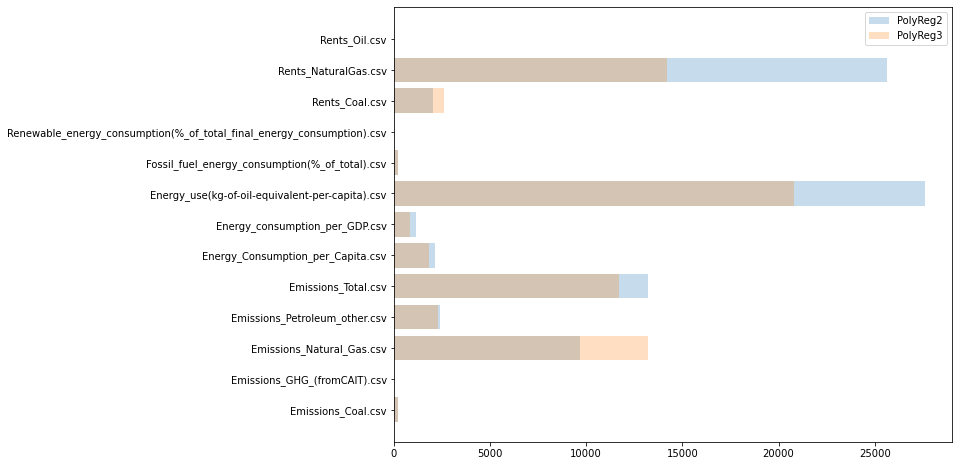

In [451]:
fig = plt.figure(figsize=(10, 8))
[#plt.barh(df_err.index, df_err['LinReg'], alpha = 0.5,align='edge', label='LinReg'), 
plt.barh(df_err.index, df_err['PolyReg2'], alpha = 0.25, label='PolyReg2'), 
plt.barh(df_err.index, df_err['PolyReg3'], alpha = 0.25, label='PolyReg3')]
plt.legend()

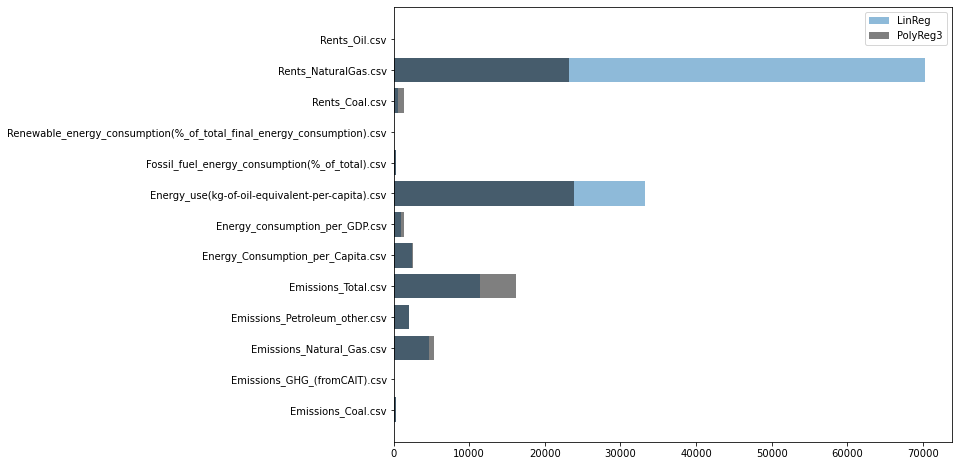

In [387]:
fig = plt.figure(figsize=(10, 8))
[plt.barh(df_err.index, df_err['LinReg'], alpha = 0.5, label='LinReg'), 
#plt.barh(df_err.index, df_err['PolyReg2'], alpha = 0.5, label='PolyReg2'), 
plt.barh(df_err.index, df_err['PolyReg3'], alpha = 0.5, label='PolyReg3', color = 'black')]
plt.title('Mean Absolute Error Comparison')
plt.legend()

In [379]:
df_err

,LinReg,PolyReg2,PolyReg3,PolyReg3-nonoise
Emissions_Coal.csv,"(296.9157938090562,)",233.603508,237.846754,32.202296
Emissions_GHG_(fromCAIT).csv,"(0.0,)",0.000000,0.000000,0.000000
Emissions_Natural_Gas.csv,"(3141.5272680724256,)",6903.579955,5113.598092,201.246413
Emissions_Petroleum_other.csv,"(1727.882299334693,)",2390.819848,2102.118135,83.595802
Emissions_Total.csv,"(12451.346508279566,)",7861.956344,10021.555903,85.722855
Energy_Consumption_per_Capita.csv,"(2058.199594100415,)",2292.706099,2046.937245,74.151648
Energy_consumption_per_GDP.csv,"(1201.9763825679954,)",750.940022,974.243447,82.986645
Energy_use(kg-of-oil-equivalent-per-capita).csv,"(27727.86411184315,)",29082.871153,23443.436423,25.302821
Fossil_fuel_energy_consumption(%_of_total).csv,"(206.9445711641092,)",252.945067,229.691340,20.256970
Renewable_energy_consumption(%_of_total_final_energy_consumption).csv,"(8.248141305293203,)",7.680888,7.535356,1.278906


### Saving files

In [130]:
# save csv in file
path = r"C:\Users\fabio\Documents\GitHub\EIB2_ClimateRisk\cleaned data\data_imputed\imputed_knn"

for i in range(len(df_list)):
    KNNimpute(df_list[i]).to_csv(path +"/" + df_names[i])

<BarContainer object of 15 artists>

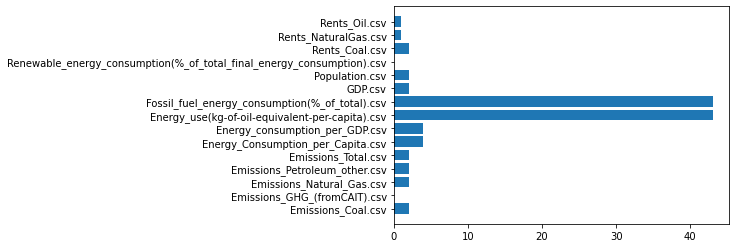

In [445]:
df_missing_ct = pd.DataFrame(columns=df_names, index = df.columns)

for i in range(len(df_list)):
    count = 0
    df = clean_df(df_list[i])
    for j in df.columns:
        if df[j].isnull().sum() >14:
            #print('in df',df_names[i] ,'A country has: ',df[j].isnull().sum(), 'missing values')
            count += 1
    df_missing_ct[df_names[i]] = count
df_missing_ct
plt.barh(df_missing_ct.columns, df_missing_ct.max())

<ipython-input-448-4370f1683cd1>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = 45)


[Text(0, 0, '0'),
 Text(1, 0, '1'),
 Text(2, 0, '2'),
 Text(3, 0, '3'),
 Text(4, 0, '4'),
 Text(5, 0, '5'),
 Text(6, 0, '6'),
 Text(7, 0, '7'),
 Text(8, 0, '8'),
 Text(9, 0, '9'),
 Text(10, 0, '10'),
 Text(11, 0, '11'),
 Text(12, 0, '12'),
 Text(13, 0, '13'),
 Text(14, 0, '14'),
 Text(15, 0, '15'),
 Text(16, 0, '16'),
 Text(17, 0, '17'),
 Text(18, 0, '18'),
 Text(19, 0, '19'),
 Text(20, 0, '20'),
 Text(21, 0, '21'),
 Text(22, 0, '22'),
 Text(23, 0, '23'),
 Text(24, 0, '24'),
 Text(25, 0, '25'),
 Text(26, 0, '26'),
 Text(27, 0, '27'),
 Text(28, 0, '28'),
 Text(29, 0, '29')]

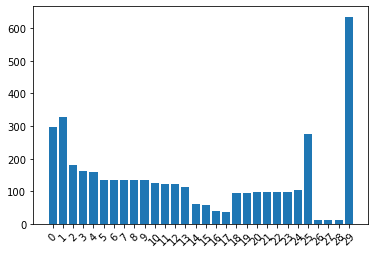

In [448]:
df_missing = pd.DataFrame(columns=df_names)
for i in range(len(df_list)):
    df = clean_df(df_list[i]).transpose()
    for j in df.columns:
        if df[j].isnull().sum() >3:
                #print('in df',df_names[i] ,'in year',j ,' has: ',df[j].isnull().sum(), 'missing values')
                df_missing[df_names[i]] = df.isnull().sum()

df_missing.transpose().sum().shape,df_missing.transpose().columns
plt.bar(df_missing.transpose().columns, df_missing.transpose().sum())
ax = plt.gca()
ax.set_xticklabels(ax.get_xticks(), rotation = 45)